In [282]:
import matplotlib.pyplot as mpl
%matplotlib inline
import numpy
import pandas
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.cluster
import sklearn.metrics
import sklearn.linear_model
import sklearn.covariance
import tabulate
import sqlite3

I downloaded the [NYSED report card data](https://data.nysed.gov/files/reportcards/14-15/SRC2015.zip) and converted the MDB Microsoft Access database (***grumble grumble grumble***) to SQLite for future improved accessibility and collaboration.  Unfortunately, I'm on OSX and wasn't able to easily convert, so I downloaded a trial version of [MDB Viewer](http://eggerapps.at/mdbviewer/), which filters outs half of the rows during export when using the unpaid version.  I'm pretty sure it throws out a random subset, but these results are obviously garbage if what it discarded is in any way correlated with the slices of data we're looking at.  I'm happy to rerun this with the full database if someone is willing to export it from MDB for me or buy me a $20 license for it.

In [283]:
connection = sqlite3.connect('SRC2015.sqlite')

There are a lot of different components of your prompt to tease out.  As I understand it based on your original post and some of the discussions you had in the comments, you're essentially asking about two things:

1. how can you determine "high poverty" in a principled, data-driven, non-arbitrary manner?
2. given a better (non-arbitrary) way of assessing "high poverty," can we identify schools that outperform expectation given povery (and potentially other explanatory factors)?

One anecdotal aspect you refer to several times is that (2) is complicated by some non-linearity.  You believe it is much more difficult to overachieve in "high poverty" (whatever that means) than it is to overachieve in a school with 80% poverty, and that a bifurcation in performance occurs with respect to poverty once poverty is too pervasive.

The first thing I'm curious about is the distribution of our main povery metrics (% of students eligible for free lunch, % of students eligible for reduced-price lunch).  These are available in the data by school.  

First let's grab the data.  Note I'm only looking at 2014 (last year for which this data set appears complete), filtering only public elementary schools which have ELA3 results (ignoring aggregations), and there seemed to be a few goofy outliers with bad data, so I'm filtering out unreasonable results too.  While I'm in the database, I'll also grab some performance metrics from the accountability table.

In [284]:
query = '''
select
    "Demographic Factors".entity_cd,
    "Demographic Factors".per_free_lunch,
    "Demographic Factors".per_reduced_lunch,
    "Demographic Factors".per_ecdis,
    "ELA3 Subgroup Results".mean_score as "ELA",
    "Math3 Subgroup Results".mean_score as "MATH"
from "Demographic Factors"
join "Institution Grouping" on "Institution Grouping".entity_cd == "Demographic Factors".entity_cd
join "ELA3 Subgroup Results" on "ELA3 Subgroup Results".entity_cd == "Demographic Factors".entity_cd
join "Math3 Subgroup Results" on "Math3 Subgroup Results".entity_cd == "Demographic Factors".entity_cd
where
    "Institution Grouping".group_name == "Public School" and
    "Demographic Factors".year == "2014" and
    "Demographic Factors".per_free_lunch <= 100 and
    "Demographic Factors".per_free_lunch >= 0 and
    "Demographic Factors".per_reduced_lunch <= 100 and
    "Demographic Factors".per_reduced_lunch >= 0 and
    "Demographic Factors".per_reduced_lunch + "Demographic Factors".per_free_lunch <= 100 and
    "ELA3 Subgroup Results".year == "2014" and
    "ELA3 Subgroup Results".subgroup_name == "All Students" and
    "ELA3 Subgroup Results".mean_score != "s" and
    "Math3 Subgroup Results".year == "2014" and
    "Math3 Subgroup Results".subgroup_name == "All Students" and
    "Math3 Subgroup Results".mean_score != "s"
'''

data = pandas.read_sql(query, connection)

Let's visualize the relationship between reduce price and free lunch percentages.  Here, lighter colors mean more likely.  I'm expecting a pretty good correlation between those eligible for free lunch and those eligible for reduced price lunch.

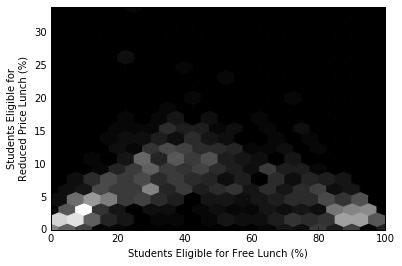

In [285]:
mpl.figure()
mpl.hexbin(data['PER_FREE_LUNCH'], data['PER_REDUCED_LUNCH'], gridsize=20, cmap='gist_gray')
mpl.xlabel('Students Eligible for Free Lunch (%)')
mpl.ylabel('Students Eligible for\nReduced Price Lunch (%)')
mpl.show()

Couple of interesting things jump out of at me.  I expected the behavior below 40% free, but the behavior above surprised me for two reasons:

1. I didn't expect the "gap" (dark area) between 55% and 75%
2. I didn't expect the relationship to have multiple segments (changing slopes around 50%).

In retrospect, (2) makes sense, because at some point the percent of students eligible for free lunch begins to cannibalize (pardon terrible pun) percent of students eligible for reduced price lunch (eg, if 100% are eligible for free lunch, 0% are eligible for reduced price ipso facto).

However, (1) has me puzzled.  Is this due to policy (eg, administrators trying to inflate numbers to get above a % free lunch threshold to become eligible for additional aid), or does this reflect the actual distribution in poverty in NYS (eg, "haves" vs "have-nots" with not much in the middle), is it some combination, or something else entirely?  Would love to hear from a domain expert on this.

We can trade one arbitrary threhsold to define poverty for another by looking at these metrics as a cumulative distribution.  Let's consider the combined metric of all students eligible for either reduced or free lunch.  We can also look at what percentage of elementary schools in NYS meet the National Center for Education Statistics 75% threshold.

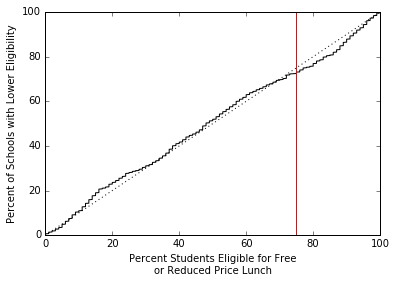

In [286]:
percent_reduced_or_free_lunch = data['PER_FREE_LUNCH'] + data['PER_REDUCED_LUNCH']

cdf = numpy.sort(percent_reduced_or_free_lunch)
y = numpy.linspace(0, 100, len(cdf))

mpl.figure()
mpl.plot(cdf, y, 'k')
mpl.plot(y, y, 'k:')
mpl.plot((75, 75), (0, 100), 'r-')
mpl.xlim(0, 100)
mpl.ylim(0, 100)
mpl.xlabel('Percent Students Eligible for Free\nor Reduced Price Lunch')
mpl.ylabel('Percent of Schools with Lower Eligibility')
mpl.show()

This is remarkably linear!  So about about 75% of schools do not meet the National Center for Education Statistics threshold of 75% of students eligible for free or reduced price lunch.  Put another way, about 25% of elementary schools in NYS are "high poverty" per NCES.

The final thing to check out is the relationship between this combined metric and the "percent of economically disadvantaged students" which is included in the data but isn't really well-defined.

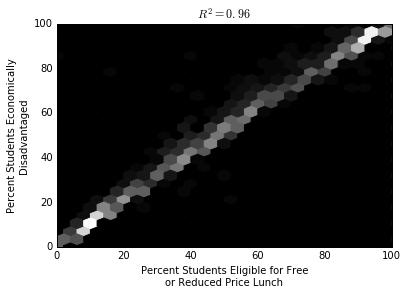

In [287]:
mpl.figure()
rsq = sklearn.metrics.r2_score(percent_reduced_or_free_lunch, data['PER_ECDIS'])
mpl.title('$R^2={:.2f}$'.format(rsq))
mpl.hexbin(percent_reduced_or_free_lunch, data['PER_ECDIS'], gridsize=25, cmap='gist_gray')
mpl.xlabel('Percent Students Eligible for Free\nor Reduced Price Lunch')
mpl.ylabel('Percent Students Economically\nDisadvantaged')
mpl.show()

If this correlation isn't definitional (eg, if ECDIS isn't only a function of percent of students eligible for free or reduced price lunch, or if eligibility for free or reduced price lunch is predicated on ECDIS), it's interesting.  If the correlation is definitional, the data set is imperfect.

Let's look at the relationship between our poverty metric and some performance metrics.

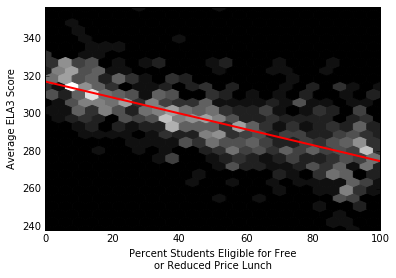

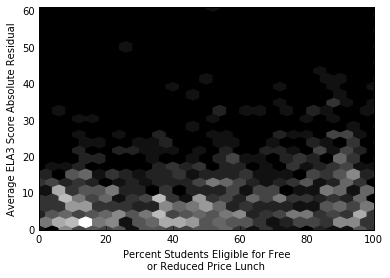

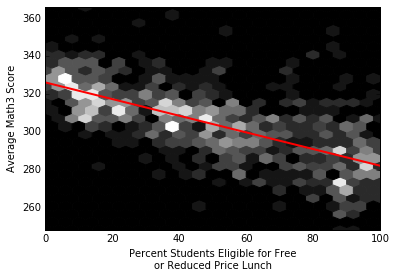

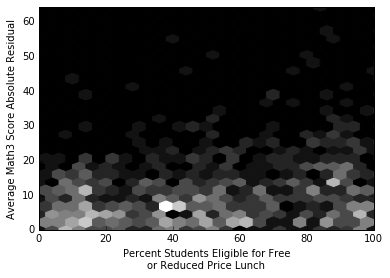

In [288]:
ela3_average_score = pandas.to_numeric(data['ELA'])
math3_average_score = pandas.to_numeric(data['MATH'])

ela3_model = sklearn.linear_model.LinearRegression()
ela3_model.fit(numpy.reshape(percent_reduced_or_free_lunch, (-1, 1)), numpy.reshape(ela3_average_score, (-1, )))
math3_model = sklearn.linear_model.LinearRegression()
math3_model.fit(numpy.reshape(percent_reduced_or_free_lunch, (-1, 1)), numpy.reshape(math3_average_score, (-1, )))

mpl.figure()
mpl.hexbin(percent_reduced_or_free_lunch, ela3_average_score, gridsize=25, cmap='gist_gray')
mpl.plot(
    numpy.linspace(0, 100),
    ela3_model.predict(numpy.reshape(numpy.linspace(0, 100), (-1, 1))), 
    'r', 
    lw=2,
)
mpl.xlabel('Percent Students Eligible for Free\nor Reduced Price Lunch')
mpl.ylabel('Average ELA3 Score')
mpl.show()

residuals = numpy.abs(ela3_average_score - ela3_model.predict(numpy.reshape(percent_reduced_or_free_lunch, (-1, 1))))
mpl.figure()
mpl.hexbin(percent_reduced_or_free_lunch, residuals, gridsize=25, cmap='gist_gray')
mpl.xlabel('Percent Students Eligible for Free\nor Reduced Price Lunch')
mpl.ylabel('Average ELA3 Score Absolute Residual')
mpl.show()

mpl.figure()
mpl.hexbin(percent_reduced_or_free_lunch, math3_average_score, gridsize=25, cmap='gist_gray')
mpl.plot(
    numpy.linspace(0, 100),
    math3_model.predict(numpy.reshape(numpy.linspace(0, 100), (-1, 1))), 
    'r', 
    lw=2,
)
mpl.xlabel('Percent Students Eligible for Free\nor Reduced Price Lunch')
mpl.ylabel('Average Math3 Score')
mpl.show()

residuals = numpy.abs(math3_average_score - math3_model.predict(numpy.reshape(percent_reduced_or_free_lunch, (-1, 1))))
mpl.figure()
mpl.hexbin(percent_reduced_or_free_lunch, residuals, gridsize=25, cmap='gist_gray')
mpl.xlabel('Percent Students Eligible for Free\nor Reduced Price Lunch')
mpl.ylabel('Average Math3 Score Absolute Residual')
mpl.show()

I'm not seeing much evidence of the bifurcation effect you mentioned.  In fact, I'm seeing something similar to what Dana saw in the NYT data visualization: if anything, it appears that "high poverty" students overachieve (and underachieve) ***more*** than their economically-well-off counterparts.  This is especially true if you normalize by achievement (that is, a 10 point increase to a test score of 280 is much larger in relative terms than a 10 point increase to a score of 320, assuming the test and grading are well-calibrated).  We could quantify that, but it's less interesting to me at this point.  It's also possible that perhaps the effect you're thinking of shows up in different measures of achievement.  However, I want to look at this from a different angle.

What I'm more interested in is whether poverty is telling the whole story.  For example, we (very unfortunately) know the reality of the race gap in achievement, and we also know that race (very unfortunately) is correlated with poverty.  These are tough realities, and it's also tough to tease out causation and understand and model the different interactions between these factors and how they influence achievement.  For example, controlling for poverty, do we know whether the racial achievement gap persists?  Does that change depending on whether we're in an urban or rural environment?  We also suspect that staffing turnover, school overcrowding, district and school policies (including those related to discipline/suspension), and other non-demographic factors could also influence achievement.  However, these are also tough to model.

You point out a lot of issues with benchmarking achievement expectations off a regression, and I agree.  The regression model is also tough to build well.  What if instead, we look at schools that are similar across the dimensions we believe are important (not just surrogates of poverty, like percent free lunches, but also percent ESL, racial breakdown, student-to-teacher ratio, etc) to define our benchmark.  Perhaps when we control for more of these factors, we'll find the bifurcation you're talking about.

What I recommend is using a nearest neighbor regression.  Find (say) 30 schools similar to the one in question across key demographics.  Then, rank the performance of that school relative to its "cousins."  One nice thing about this approach is that you can naturally apply outlier detection analysis to the cohort of similar schools.

You can also cluster the schools a priori, which might show surprising groupings.

Let's give it a try.  First, let's grab everything we think might impact achievement from the database.

In [289]:
query = '''
select
    "BOCES and N/RC".entity_cd,
    "BOCES and N/RC".school_name,
    "BOCES and N/RC".district_cd,
    "BOCES and N/RC".district_name,
    "Demographic Factors".per_free_lunch,
    "Demographic Factors".per_reduced_lunch,
    "Demographic Factors".per_ecdis,
    "Demographic Factors".per_lep,
    "Demographic Factors".per_am_ind,
    "Demographic Factors".per_black,
    "Demographic Factors".per_hisp,
    "Demographic Factors".per_asian,
    "Demographic Factors".per_white,
    "Demographic Factors".per_multi as PER_MULTI,
    "Demographic Factors".per_swd,
    "Demographic Factors".per_male,
    (
        "BEDS Day Enrollment".pk +
        "BEDS Day Enrollment".khalf +
        "BEDS Day Enrollment".kfull +
        "BEDS Day Enrollment"."1" +
        "BEDS Day Enrollment"."2" +
        "BEDS Day Enrollment"."3" +
        "BEDS Day Enrollment"."4" +
        "BEDS Day Enrollment"."5" +
        "BEDS Day Enrollment"."6" +
        "BEDS Day Enrollment"."7" +
        "BEDS Day Enrollment"."8"
    ) as "NUM_ENROLLED",
    "Staff".num_teach,
    "Staff".per_no_valid_cert,
    "Staff".per_teach_out_cert,
    "Staff".per_fewer_3yrs_exp,
    "Staff".per_mas_plus,
    "Staff".per_not_hq,
    "Staff".per_no_approp_cert,
    "Staff".per_turn_five_yrs,
    "Staff".per_turn_all,
    "Staff".num_ft_oth_prof_staff,
    "Staff".num_pt_oth_prof_staff,
    "Staff".num_ft_paraprofessionals,
    "Staff".num_pt_paraprofessionals,
    "Staff".num_ft_principals,
    "Staff".num_pt_principals,
    "Staff".num_ft_asst_principals,
    "Staff".num_pt_asst_principals,
    "Attendance and Suspensions".attendance_rate,
    "Attendance and Suspensions".per_suspensions,
    CAST("BOCES and N/RC".needs_index as INTEGER) as "NEEDS_INDEX",
    CAST("ELA3 Subgroup Results".mean_score as INTEGER) as "ELA",
    CAST("Math3 Subgroup Results".mean_score as INTEGER) as "MATH"
from "Demographic Factors"
join "Institution Grouping" on "Institution Grouping".entity_cd == "Demographic Factors".entity_cd
join "ELA3 Subgroup Results" on "ELA3 Subgroup Results".entity_cd == "Demographic Factors".entity_cd
join "Math3 Subgroup Results" on "Math3 Subgroup Results".entity_cd == "Demographic Factors".entity_cd
join "Staff" on "Staff".entity_cd == "Demographic Factors".entity_cd
join "BEDS Day Enrollment" on "BEDS Day Enrollment".entity_cd == "Demographic Factors".entity_cd
join "BOCES and N/RC" on "BOCES and N/RC".entity_cd == "Demographic Factors".entity_cd
join "Attendance and Suspensions" on "Attendance and Suspensions".entity_cd == "Demographic Factors".entity_cd
where
    "Institution Grouping".group_name == "Public School" and
    "Demographic Factors".year == "2014" and
    "Demographic Factors".per_free_lunch <= 100 and
    "Demographic Factors".per_free_lunch >= 0 and
    "Demographic Factors".per_reduced_lunch <= 100 and
    "Demographic Factors".per_reduced_lunch >= 0 and
    "Demographic Factors".per_reduced_lunch + "Demographic Factors".per_free_lunch <= 100 and
    "Attendance and Suspensions".year == "2014" and
    "BOCES and N/RC".year == "2014" and
    "Staff".year == "2014" and
    "BEDS Day Enrollment".year == "2014" and
    "ELA3 Subgroup Results".year == "2014" and
    "ELA3 Subgroup Results".subgroup_name == "All Students" and
    "ELA3 Subgroup Results".mean_score != "s" and
    "Math3 Subgroup Results".year == "2014" and
    "Math3 Subgroup Results".subgroup_name == "All Students" and
    "Math3 Subgroup Results".mean_score != "s"
'''

data = pandas.read_sql(query, connection)

Let's decompose the demographic data to reduce the dimension and lump together colinear variates.  We'll use 3 principal components, which explains ~95% of the variance in the demographic data.

Component 1 explains 73.9% of variance
Component 2 explains 11.6% of variance
Component 3 explains 9.0% of variance
A total of 94.5% of variance is explained with 3 principal components.


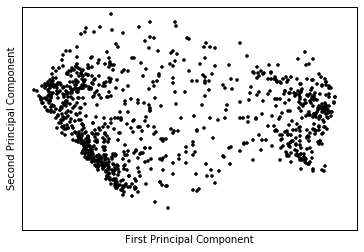

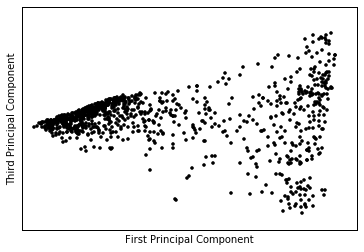

In [290]:
demographic_columns = [
    'PER_FREE_LUNCH',
    'PER_REDUCED_LUNCH',
    'PER_ECDIS',
    'PER_LEP',
    'PER_AM_IND',
    'PER_BLACK',
    'PER_HISP',
    'PER_ASIAN',
    'PER_WHITE',
    'PER_MULTI',
    'PER_SWD',
]
demographics = data[demographic_columns]

Ncomponents = 3
pca = sklearn.decomposition.PCA(Ncomponents, whiten=True)
demographic_components = pca.fit_transform(demographics)
for i in range(Ncomponents):
    print('Component {} explains {:.1f}% of variance'.format(i + 1, 100*pca.explained_variance_ratio_[i]))
print('A total of {:.1f}% of variance is explained with {} principal components.'.format(
        100*pca.explained_variance_ratio_.sum(),
        Ncomponents
))

mpl.figure()
mpl.plot(demographic_components[:, 0], demographic_components[:, 1], 'k.')
mpl.xlabel('First Principal Component')
mpl.ylabel('Second Principal Component')
mpl.xticks([])
mpl.yticks([])
mpl.show()

mpl.figure()
mpl.plot(demographic_components[:, 0], demographic_components[:, 2], 'k.')
mpl.xlabel('First Principal Component')
mpl.ylabel('Third Principal Component')
mpl.xticks([])
mpl.yticks([])
mpl.show()

I'm curious about how well these principal components track with the needs index definition.

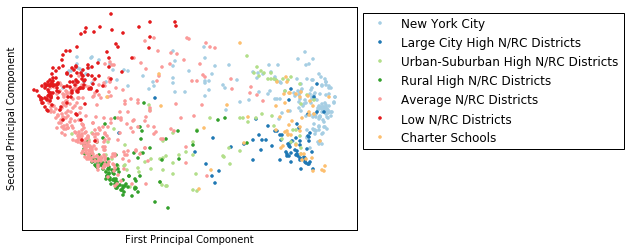

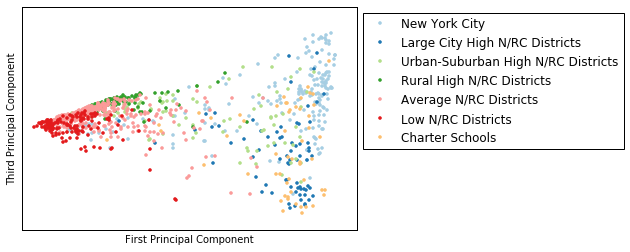

In [291]:
needs_index = numpy.asarray(data['NEEDS_INDEX'])
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']

labels = [
    'New York City', 
    'Large City High N/RC Districts', 
    'Urban-Suburban High N/RC Districts', 
    'Rural High N/RC Districts', 
    'Average N/RC Districts',
    'Low N/RC Districts',
    'Charter Schools',
]

mpl.figure()
mpl.hold(True)
for i, c, l in zip(numpy.unique(needs_index), colors, labels):
    try:
        j = numpy.where(i == needs_index)
        numpy.random.shuffle(j[0])
        mpl.plot(
            numpy.reshape(demographic_components[j, 0], (-1, )),
            numpy.reshape(demographic_components[j, 1], (-1, )), 
            '.', color=c, label=l
        )
    except:
        pass
mpl.xlabel('First Principal Component')
mpl.ylabel('Second Principal Component')
mpl.xticks([])
mpl.yticks([])
mpl.legend(loc="upper left", bbox_to_anchor=(1, 1), numpoints=1)
mpl.show()

mpl.figure()
mpl.hold(True)
for i, c, l in zip(numpy.unique(needs_index), colors, labels):
    try:
        j = numpy.where(i == needs_index)
        numpy.random.shuffle(j[0])
        mpl.plot(
            numpy.reshape(demographic_components[j, 0], (-1, )),
            numpy.reshape(demographic_components[j, 2], (-1, )), 
            '.', color=c, label=l
        )
    except:
        pass
mpl.xlabel('First Principal Component')
mpl.ylabel('Third Principal Component')
mpl.xticks([])
mpl.yticks([])
mpl.legend(loc="upper left", bbox_to_anchor=(1, 1), numpoints=1)
mpl.show()

It clusters more coherently than I would have expected, which suggests their segmentation is reasonable.  I note that there is quite a bit of dispersion in NYC, which I think makes sense given the diversity of schools you find in NYC.

In [292]:
columns = [
    'PER_FREE_LUNCH', 
    'PER_REDUCED_LUNCH',
    'PER_ECDIS',
    'PER_LEP',
    'PER_AM_IND',
    'PER_BLACK',
    'PER_HISP',
    'PER_ASIAN',
    'PER_WHITE',
    'PER_MULTI',
    'PER_SWD',
    'ATTENDANCE_RATE',
    'PER_SUSPENSIONS',
    'ELA',
    'MATH'
]

labels = []
labels.extend(['NEEDS_INDEX', 'NUM_SCHOOLS'])
labels.extend(columns)
table = []
table.append(labels)
for i in numpy.unique(needs_index):
    indx = numpy.where(i == needs_index)
    row = [i, len(indx[0])]
    row.extend(map(int, data[columns].as_matrix()[indx].mean(axis=0)))
    table.append(row)

print(tabulate.tabulate(numpy.transpose(table)))
print()

for i in numpy.unique(needs_index):
    indx = numpy.where(i == needs_index)
    row = data[['SCHOOL_NAME', 'DISTRICT_NAME']].as_matrix()[indx]
    numpy.random.shuffle(row)
    print(20*'-', 'NEEDS_INDEX = {}'.format(i), 20*'-')
    for j in range(5):
        print('  {} ({})'.format(*row[j]))
    print()

-----------------  ---  ---  ---  ---  ---  ---  ---
NEEDS_INDEX          1    2    3    4    5    6    7
NUM_SCHOOLS        193   72   84  103  320  144   54
PER_FREE_LUNCH      70   81   59   44   26    7   72
PER_REDUCED_LUNCH    3    3    6   11    7    2    7
PER_ECDIS           74   87   71   59   37   11   82
PER_LEP             16   11   10    0    2    3    7
PER_AM_IND           0    0    0    2    0    0    0
PER_BLACK           22   56   23    2    6    3   54
PER_HISP            53   20   25    5    8    9   33
PER_ASIAN            7    5    2    0    4   11    1
PER_WHITE           13   14   43   87   77   73    8
PER_MULTI            1    1    5    1    2    1    2
PER_SWD             23   19   12   14   12   12   13
ATTENDANCE_RATE     92   89   93   94   95   95   93
PER_SUSPENSIONS      0    8    4    2    1    0    9
ELA                293  267  283  287  300  315  299
MATH               299  274  288  299  310  322  310
-----------------  ---  ---  ---  ---  ---  --

Now, let's form seven clusters (corresponding to the needs index segments) in a more principled way based on demographics.  First, display a table showing aggregate stats for each of the segments, and then print five example schools from each cluster.

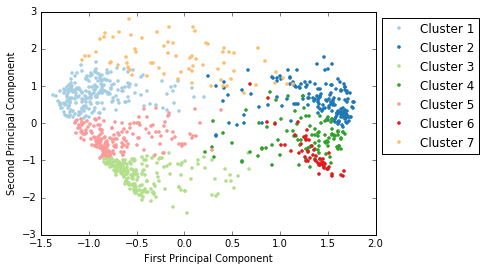

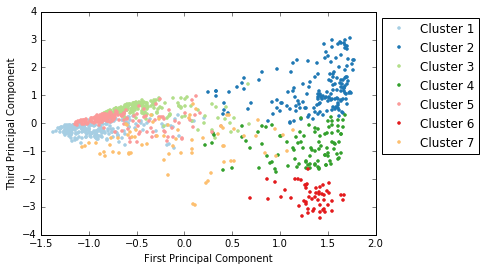

In [300]:
Nclusters = 7

cluster = sklearn.cluster.KMeans(Nclusters)
cluster.fit(demographic_components)

mpl.figure()
for i, c in zip(range(Nclusters), colors):
    indx = numpy.where(cluster.labels_ == i)
    mpl.plot(
        numpy.reshape(demographic_components[indx, 0], (-1, )), 
        numpy.reshape(demographic_components[indx, 1], (-1, )),
        '.', color=c, label='Cluster {}'.format(i + 1)
    )
mpl.xlabel('First Principal Component')
mpl.ylabel('Second Principal Component')
mpl.legend(loc="upper left", bbox_to_anchor=(1, 1), numpoints=1)
mpl.show()

mpl.figure()
mpl.hold(True)
for i, c in zip(range(Nclusters), colors):
    indx = numpy.where(cluster.labels_ == i)
    mpl.plot(
        numpy.reshape(demographic_components[indx, 0], (-1, )), 
        numpy.reshape(demographic_components[indx, 2], (-1, )),
        '.', color=c, label='Cluster {}'.format(i + 1)
    )
mpl.xlabel('First Principal Component')
mpl.ylabel('Third Principal Component')
mpl.legend(loc="upper left", bbox_to_anchor=(1, 1), numpoints=1)
mpl.show()

In [301]:
columns = [
    'PER_FREE_LUNCH', 
    'PER_REDUCED_LUNCH',
    'PER_ECDIS',
    'PER_LEP',
    'PER_AM_IND',
    'PER_BLACK',
    'PER_HISP',
    'PER_ASIAN',
    'PER_WHITE',
    'PER_MULTI',
    'PER_SWD',
    'ATTENDANCE_RATE',
    'PER_SUSPENSIONS',
    'ELA',
    'MATH'
]

labels = []
labels.extend(['CLUSTER', 'NUM_SCHOOLS'])
labels.extend(columns)
table = []
table.append(labels)
for i in range(Nclusters):
    indx = numpy.where(cluster.labels_ == i)
    row = [i + 1, len(indx[0])]
    row.extend(map(int, data[columns].as_matrix()[indx].mean(axis=0)))
    table.append(row)

print(tabulate.tabulate(numpy.transpose(table)))
print()

for i in range(Nclusters):
    indx = numpy.where(cluster.labels_ == i)
    row = data[['SCHOOL_NAME', 'DISTRICT_NAME']].as_matrix()[indx]
    numpy.random.shuffle(row)
    print(30*'-', 'CLUSTER = {}'.format(i + 1), 30*'-')
    for j in range(5):
        print('  {} ({})'.format(*row[j]))
    print()

-----------------  ---  ---  ---  ---  ---  ---  ---
CLUSTER              1    2    3    4    5    6    7
NUM_SCHOOLS        227  163  191   96  170   53   70
PER_FREE_LUNCH      10   80   45   80   27   80   22
PER_REDUCED_LUNCH    3    4   10    4    8    5    4
PER_ECDIS           15   85   60   87   39   86   31
PER_LEP              2   21    0   12    1    3    9
PER_AM_IND           0    0    0    1    0    0    0
PER_BLACK            3   21    3   49    4   80   17
PER_HISP            10   68    4   29    6   10   24
PER_ASIAN            7    3    0    5    2    1   26
PER_WHITE           75    6   87   10   83    4   28
PER_MULTI            2    0    2    2    3    1    2
PER_SWD             12   21   14   19   11   16   12
ATTENDANCE_RATE     95   92   93   91   95   91   96
PER_SUSPENSIONS      0    1    3    4    1   11    0
ELA                313  285  289  279  299  280  313
MATH               320  291  299  286  308  287  321
-----------------  ---  ---  ---  ---  ---  --

Interesting!  There seem to be two clusters with strong test scores, one predominantly white with little poverty (1), and one more diverse with moderate (7) poverty.  It would be interesting to look into dispersion here.

Now, find the 30 nearest schools to each in terms of demographics, and compare how well the school in question compares to these similar schools.  These are your shining stars.

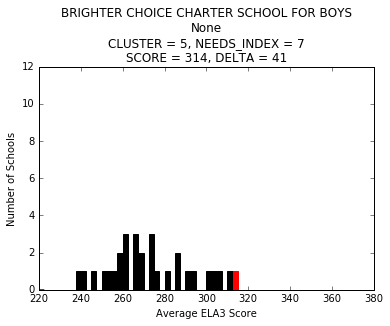

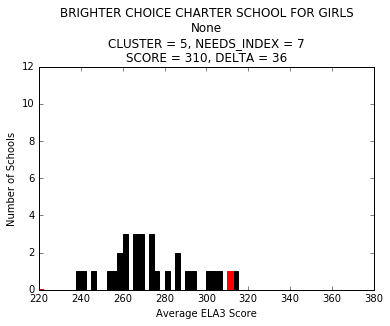

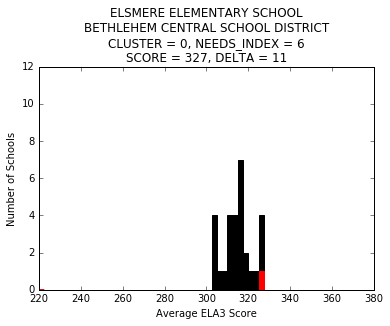

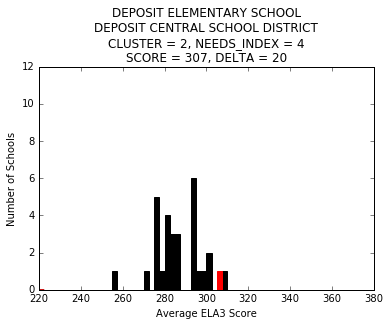

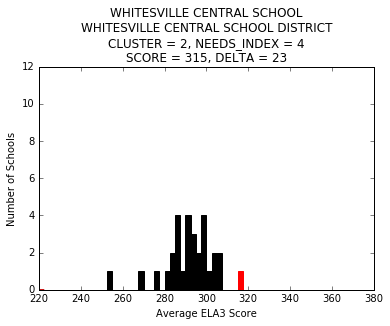

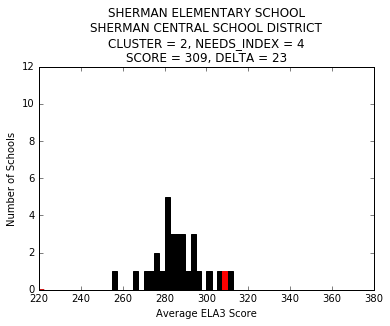

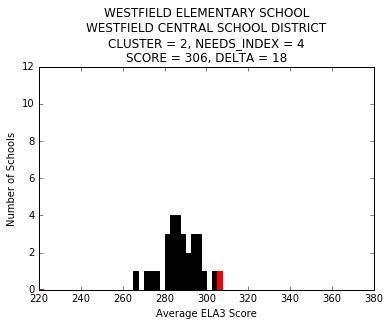

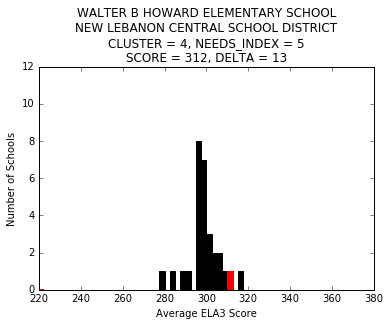

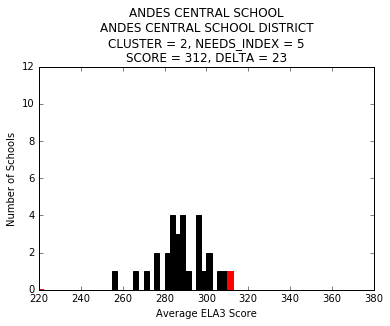

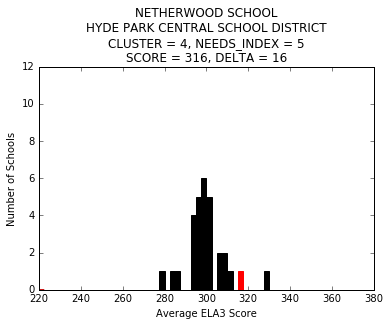

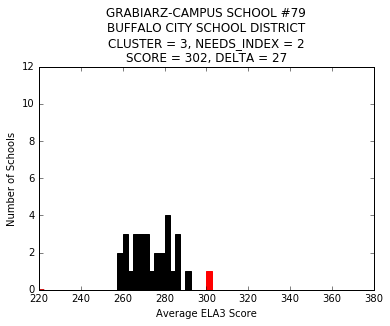

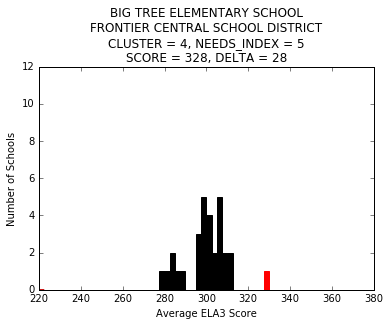

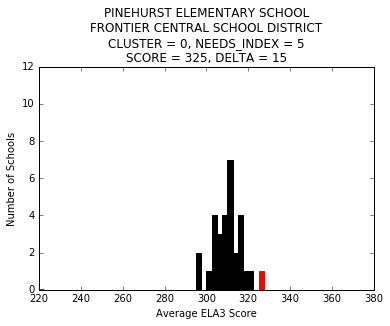

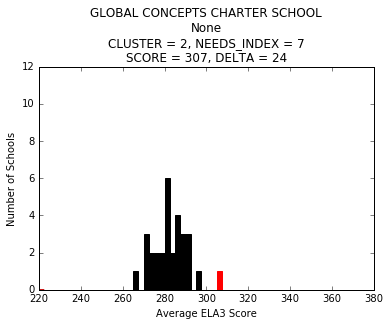

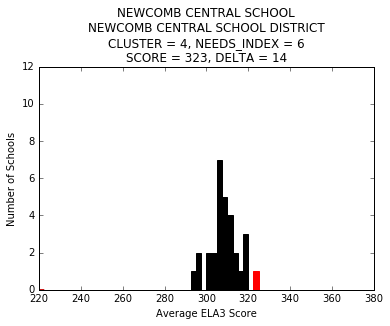

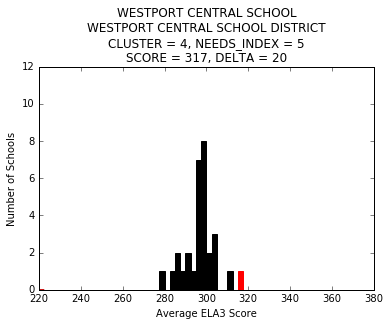

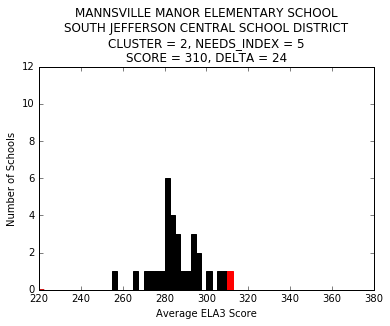

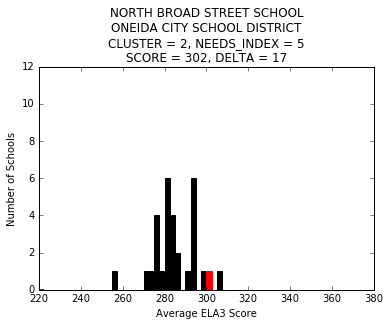

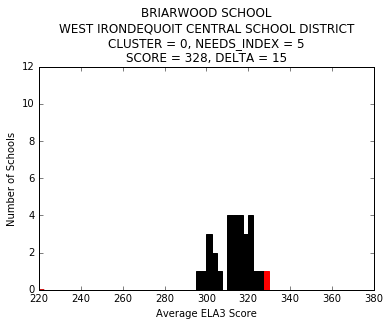

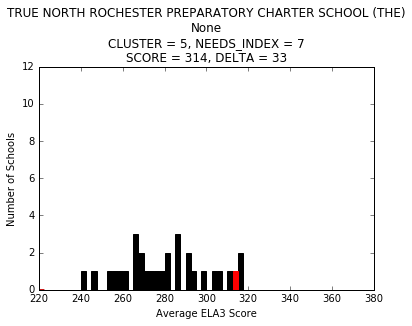

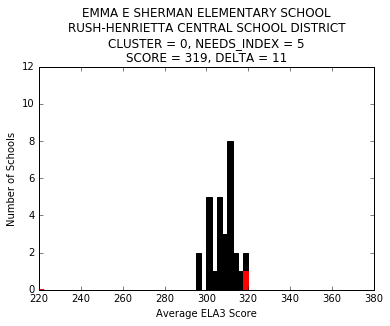

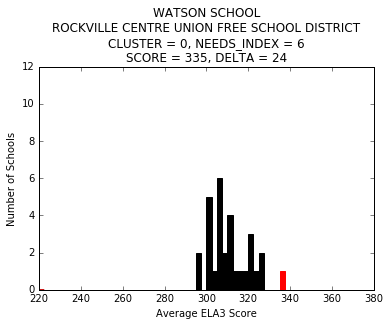

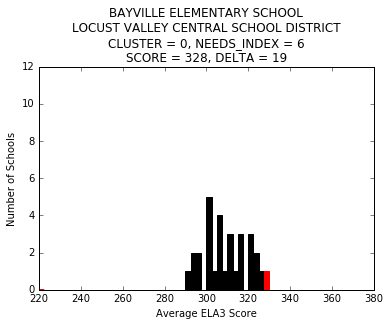

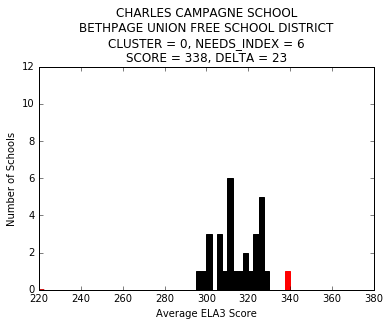

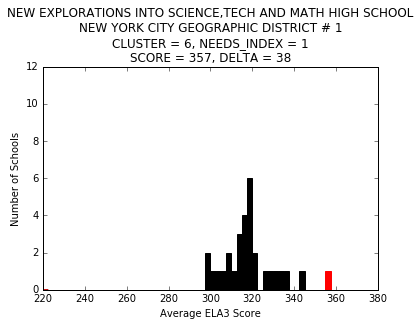

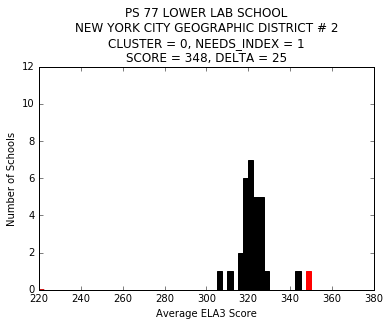

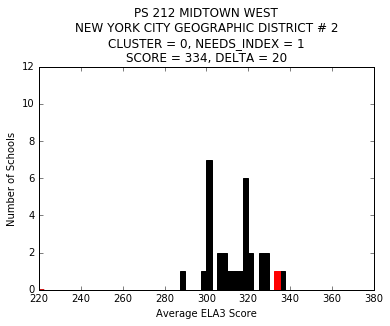

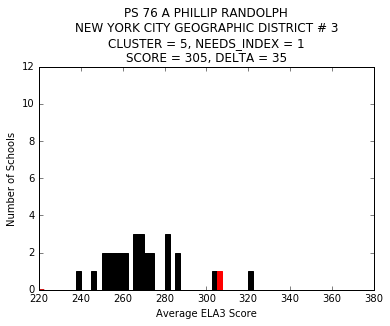

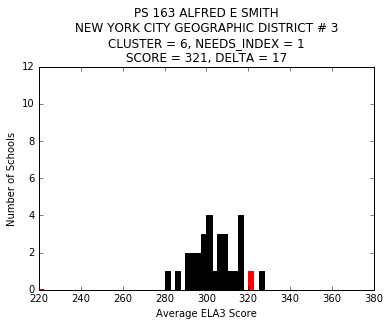

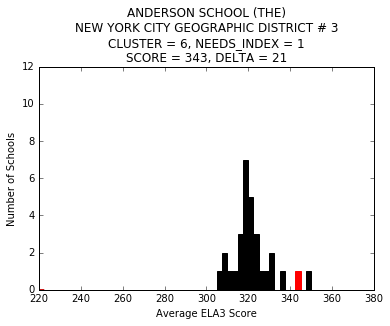

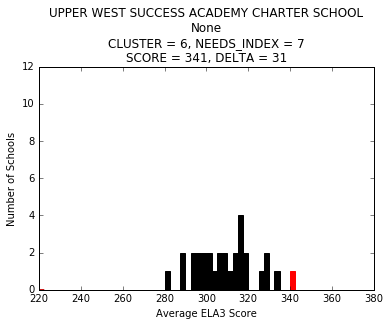

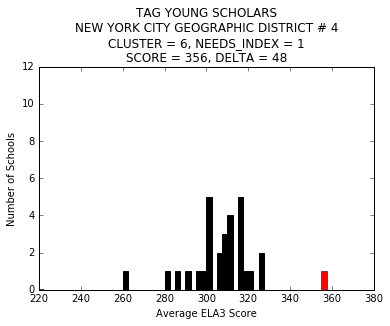

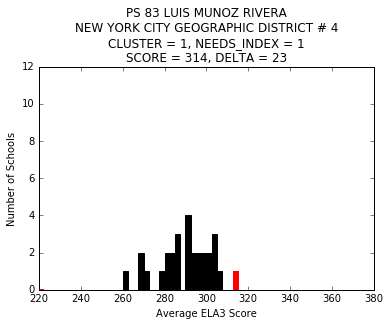

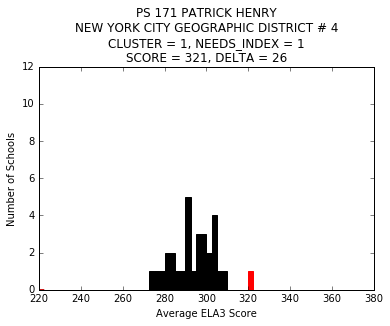

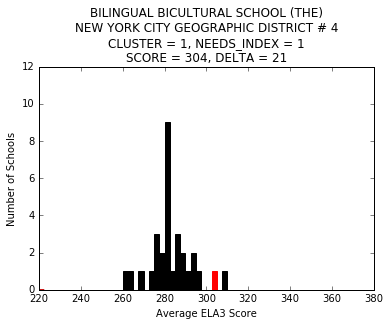

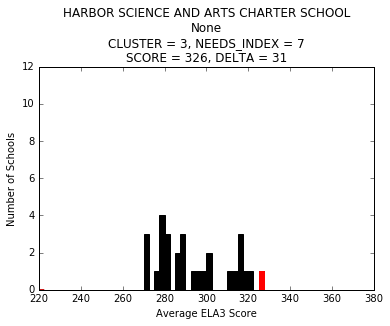

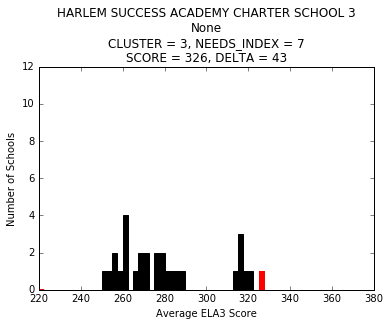

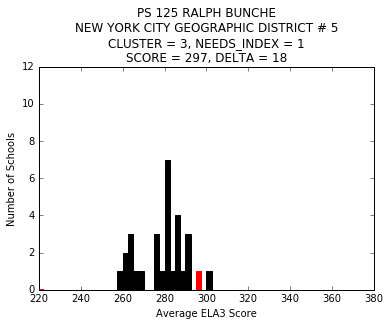

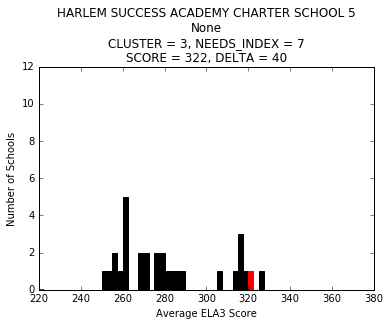

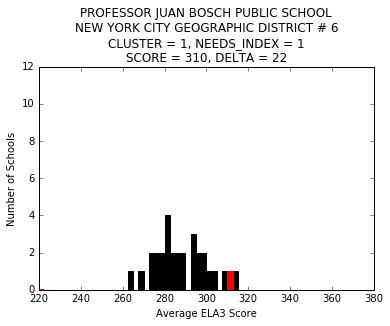

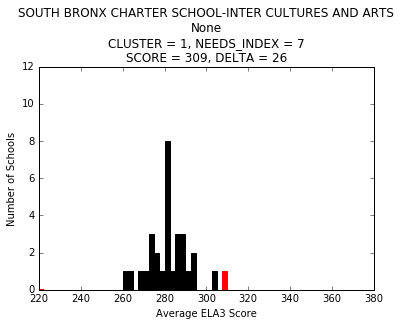

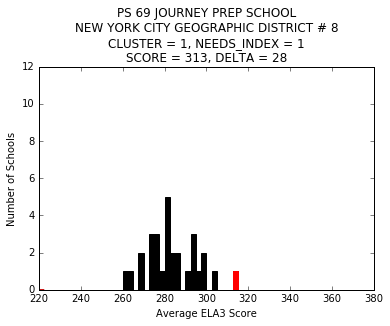

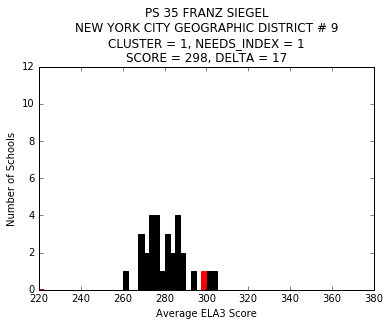

In [303]:
neighbors = sklearn.neighbors.NearestNeighbors(30)
neighbors.fit(demographics)
_, indices = neighbors.kneighbors(demographics)
Z = 1.644854 # 90% CI

for i in range(970):
    neighbor_indices = indices[i, :]
    school, district, needs_index, score = data[['SCHOOL_NAME', 'DISTRICT_NAME', 'NEEDS_INDEX', 'ELA']].as_matrix()[i]
    scores = data['ELA'].as_matrix()[neighbor_indices]
    
    p = scores.mean() + Z*numpy.std(scores)
    
    if score >= p:
        mpl.figure()
        mpl.title('{}\n{}\nCLUSTER = {}, NEEDS_INDEX = {}\nSCORE = {}, DELTA = {}'.format(
            school, district, cluster.labels_[i], needs_index, score, int(score - scores.mean())
        ))
        mpl.hist(scores[neighbor_indices != i], color='k', bins=numpy.linspace(220, 380, 65))
        mpl.hist(scores[neighbor_indices == i], color='r', edgecolor='r', bins=numpy.linspace(220, 380, 65))
        mpl.xlim(220, 380)
        mpl.ylim(0, 12)
        mpl.xlabel('Average ELA3 Score')
        mpl.ylabel('Number of Schools')
        mpl.show()

End of Document